In [1]:
import os
from pathlib import Path

import sys

current_path = %pwd
current_path = Path(current_path)
sys.path.insert(0, str(current_path.parent))

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from data import preprocessing
from models import training, baseline_10x10 as baseline_10x10_normed
from metrics import make_metric_plots, make_histograms

preprocessing._VERSION = 'data_v1'
data = preprocessing.read_csv_2d(pad_range = (39, 49), time_range = (266, 276))
data /= data.sum(axis=(1, 2), keepdims=True) / 100

data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

In [2]:
import re

In [3]:
N_LAST = 10

models = Path('../saved_models/baseline_10x10_normed').glob("generator_*.h5")
expr = re.compile(r'generator_([0-9]*)\.h5')
def getnum(model_name):
    num, = re.match(expr, model_name).groups()
    return int(num)

models = {getnum(m.name) : m for m in models}
models = [models[i].as_posix() for i in sorted(models)[-N_LAST:]]
models = [tf.keras.models.load_model(m) for m in models]

In [4]:
avg_model = training.average(models)

In [5]:
unscale = lambda x: 10**x - 1

In [6]:
from metrics import get_val_metric

In [7]:
X_gen_massive_last = unscale(
    models[-1](
        np.random.normal(size=(100000, baseline_10x10_normed.LATENT_DIM)).astype('float32')
    ).numpy()
)

X_gen_massive_avg = unscale(
    avg_model(
        np.random.normal(size=(100000, baseline_10x10_normed.LATENT_DIM)).astype('float32')
    ).numpy()
)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
metrics_real     = get_val_metric(data_test)
metrics_gen_last = get_val_metric(X_gen_massive_last)
metrics_gen_avg  = get_val_metric(X_gen_massive_avg )

In [10]:
from matplotlib.offsetbox import AnchoredText
from matplotlib import rcParams

In [11]:
def bootstrap_error(data, function, num_bs=100):
    assert data.ndim == 1
    bs_data = np.random.choice(data, size=(num_bs, len(data)), replace=True)
    return np.array([function(bs_sample) for bs_sample in bs_data]).std()

def get_stats(arr):
    class Obj:
        pass
    result = Obj()
    
    result.mean = arr.mean()
    result.width = arr.std()
    
    result.mean_err = result.width / (len(arr) - 1)**0.5
    result.width_err = bootstrap_error(arr, np.std)
    
    return result

def compare_two_dists(d_real, d_gen, label, tag=None, nbins=100):
    ax = plt.gca()
    bins = np.linspace(
        min(d_real.min(), d_gen.min()),
        max(d_real.max(), d_gen.max()),
        nbins + 1
    )
    
    stats_real = get_stats(d_real)
    stats_gen  = get_stats(d_gen )
    
    if tag:
        leg_entry = f'gen ({tag})'
    else:
        leg_entry = 'gen'
    
    plt.hist(d_real, bins=bins, density=True, label='real')
    plt.hist(d_gen , bins=bins, density=True, label=leg_entry, histtype='step', linewidth=2.)
    
    string = '\n'.join([
        f"real: mean = {stats_real.mean :.4f} +/- {stats_real.mean_err :.4f}",
        f"gen:  mean = {stats_gen .mean :.4f} +/- {stats_gen .mean_err :.4f}",
        f"real: std  = {stats_real.width:.4f} +/- {stats_real.width_err:.4f}",
        f"gen:  std  = {stats_gen .width:.4f} +/- {stats_gen .width_err:.4f}",
    ])
    default_family = rcParams['font.family']
    rcParams['font.family'] = 'monospace'
    ax.add_artist(AnchoredText(string, loc=2))
    rcParams['font.family'] = default_family
    
#     plt.text(0.01, 0.95, "real: mean = {:.4f} +/- {:.4f}".format(stats_real.mean , stats_real.mean_err ), transform=ax.transAxes)
#     plt.text(0.01, 0.88, "gen: mean = {:.4f} +/- {:.4f}" .format(stats_gen .mean , stats_gen .mean_err ), transform=ax.transAxes)
#     plt.text(0.01, 0.75, "real: std  = {:.4f} +/- {:.4f}".format(stats_real.width, stats_real.width_err), transform=ax.transAxes)
#     plt.text(0.01, 0.68, "gen: std  = {:.4f} +/- {:.4f}" .format(stats_gen .width, stats_gen .width_err), transform=ax.transAxes)
    plt.xlabel(label)
    plt.legend()

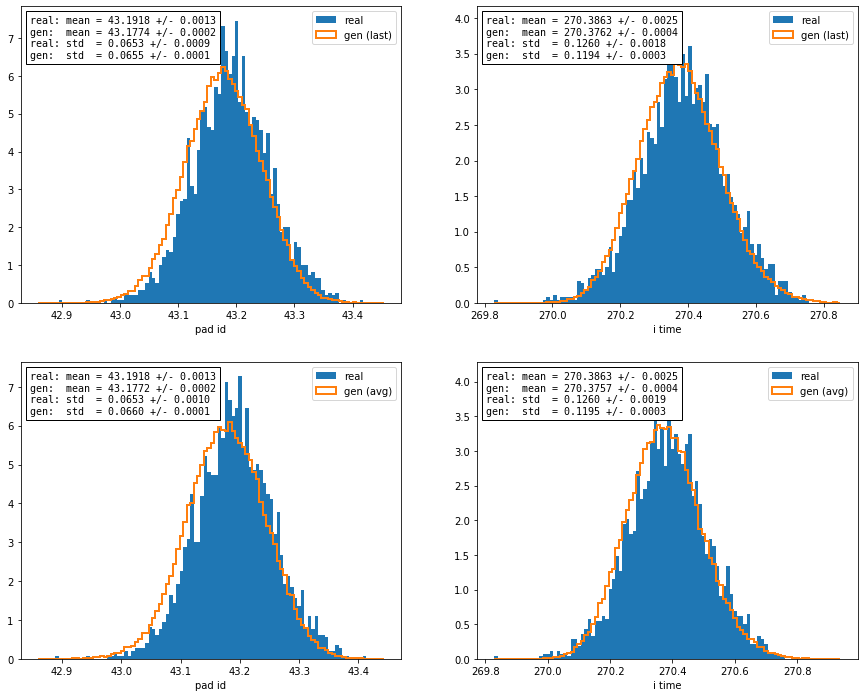

In [12]:
mean_padid_real     = metrics_real    [:,0] + 39
mean_padid_gen_last = metrics_gen_last[:,0] + 39
mean_padid_gen_avg  = metrics_gen_avg [:,0] + 39

mean_time_real     = metrics_real    [:,1] + 266
mean_time_gen_last = metrics_gen_last[:,1] + 266
mean_time_gen_avg  = metrics_gen_avg [:,1] + 266

plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1); compare_two_dists(mean_padid_real, mean_padid_gen_last, 'pad id', tag='last')
plt.subplot(2, 2, 2); compare_two_dists(mean_time_real , mean_time_gen_last , 'i time', tag='last')
plt.subplot(2, 2, 3); compare_two_dists(mean_padid_real, mean_padid_gen_avg , 'pad id', tag='avg' )
plt.subplot(2, 2, 4); compare_two_dists(mean_time_real , mean_time_gen_avg  , 'i time', tag='avg' )